# <center>COMP-3704: GROUP5
# Project: Driver Drowsiness Detection Using Deep Learning

Group members: Jasleen Kaur, Jingxiu Yin, Sulaimon Aderoju, Long Him Wong

***Introduction***  
Driver drowsiness is a significant factor in many road accidents,  
leading to substantial safety concerns. This project aims to  
develop a deep learning model capable of detecting driver  
drowsiness by analyzing images of drivers. We use the  
Driver Drowsiness Dataset (DDD) available on Kaggle,  
which contains labeled images of drowsy and non-drowsy drivers.  
And, since our local machine GPU so slow, so we use  
Kaggle and Google Colab's free tire GPUs for this project.

The dataset is located here: [Driver Drowsiness Dataset (DDD)](https://www.kaggle.com/datasets/ismailnasri20/driver-drowsiness-dataset-ddd)  
  
**Best Score: 99.99%**  
## Overview
### Objective

### 1) Data Exploration and Preprocessing

### 2) Data Augmentation

### 3) Model Development

### 4) Model Evaluation

### 5) Load Models and Generate Predictions

### 6) Real-Time Detection with Audio Alert

### 7) Conclusion

## Objective - Driver Drowsiness Detection System  
The goal of this project is to develop a real-time drowsiness detection  
system for drivers, utilizing a Convolutional Neural Network (CNN) to  
classify eye states as drowsy or non-drowsy. This system will help  
improve road safety by alerting drivers when they appear drowsy.  
We also tried transfer learning using fine-tuning. Eventually, we  
try to build a real-time computer vision detection system.

## Step 1: Data Exploration and Preprocessing

We will load the dataset, which contains images organized into  
`drowsy` and `non_drowsy` folders. The images are then preprocessed  
to ensure they match the input size required by our model.  

The dataset has the following properties :  
- RGB images  
- 2 classes (Drowsy & Non Drowsy)
    - Drowsy 22.3k
    - Non Drwsy 19.4k
- Size of image : 227 x 227  
- More than 41,790 images in total  
- File size : 3G

### Import Necessary Libraries

In [2]:
# Install necessary library
!pip install playsound==1.2.2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import joblib
import time
from playsound import playsound
from PIL import Image
from sklearn.model_selection import train_test_split

### Load and visualize the dataset to understand its structure and content

In [4]:
# # For colab dataset
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download(
#     "ismailnasri20/driver-drowsiness-dataset-ddd"
# )
# print("Path to dataset files:", path)

# # Path to dataset files:
# base_path = (
#     '/root/.cache/kagglehub/datasets/ismailnasri20/'
#     'driver-drowsiness-dataset-ddd/versions/1'
# )

In [ ]:
# # For Kaggle dataset
# Define data paths
drowsy_path = (
    '/kaggle/input/driver-drowsiness-dataset-ddd/'
    'Driver Drowsiness Dataset (DDD)/Drowsy'
)

non_drowsy_path = (
    '/kaggle/input/driver-drowsiness-dataset-ddd/'
    'Driver Drowsiness Dataset (DDD)/Non Drowsy'
)

# Get image lists
drowsy_images = os.listdir(drowsy_path)
non_drowsy_images = os.listdir(non_drowsy_path)

# Create labels
drowsy_labels = [1] * len(drowsy_images)  # 1 for drowsy
non_drowsy_labels = [0] * len(non_drowsy_images)  # 0 for non-drowsy

# Combine data
all_images = drowsy_images + non_drowsy_images
all_labels = drowsy_labels + non_drowsy_labels

### Data visualization

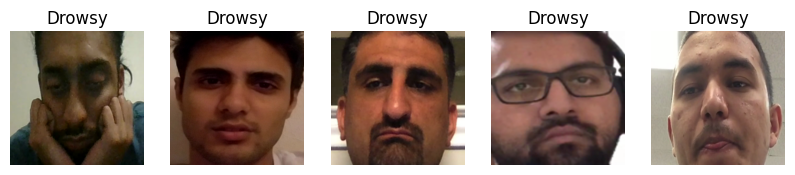

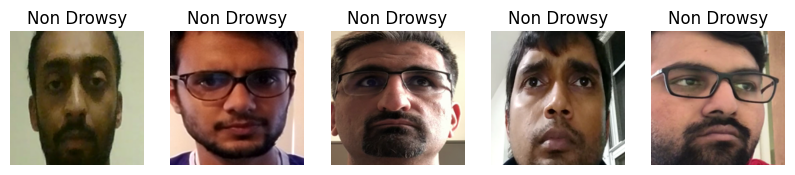

In [ ]:
# Display some sample images
plt.figure(figsize=(10, 5))
for i in range(5):
    img_path = os.path.join(drowsy_path, drowsy_images[i])
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title('Drowsy')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
for i in range(5):
    img_path = os.path.join(non_drowsy_path, non_drowsy_images[i])
    img = Image.open(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title('Non Drowsy')
    plt.axis('off')
plt.show()

### Define Image Parameters and Load Dataset

In [ ]:
# Define image parameters
img_height, img_width = 64, 64
batch_size = 128 # Local docker use 32
dataset_path = (
    "/kaggle/input/driver-drowsiness-dataset-ddd/"
    "Driver Drowsiness Dataset (DDD)"
)

# Load dataset with training and validation splits
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'binary'
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'binary'
)

Found 41793 files belonging to 2 classes.
Using 33435 files for training.
Found 41793 files belonging to 2 classes.
Using 8358 files for validation.


* Image parameters are set (height and width to 64x64, batch size of 32).
* Data is loaded from a directory structured into "drowsy" and "non_drowsy"<br> folders, with an 80-20 split for training and validation.
* Successfully loaded 43937 images into two classes, with 35156 used for<br> training and 8781 for validation.

## Step 2: Data Augmentation and Model Architecture

To improve generalization and prevent overfitting, data augmentation is applie  
. The model is a CNN with multiple convolutional and max-pooling layer  
, followed by dense layers for classificat  n.

In [ ]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define data augmentation
# data_augmentation = ImageDataGenerator(
#     rescale=1./255,
#     horizontal_flip=True,
#     zoom_range=0.2,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     rotation_range=40,
#     fill_mode='nearest',
#     validation_split=0.2  # 20% for validation
# )

# # Load and augment training data
# train_generator = data_augmentation.flow_from_directory(
#     dataset_path,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='binary',
#     subset='training'
# )

# # Load validation data
# validation_generator = data_augmentation.flow_from_directory(
#     dataset_path,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='binary',
#     subset='validation'
# )

In [ ]:
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

## Step 3: Model Development

### Build and Train a CNNs Model

In [ ]:
# Model architecture, build a CNN model
model_cnn = models.Sequential()

# Add data augmentation
model_cnn.add(data_augmentation)

# Add rescaling layer
model_cnn.add(layers.Rescaling(1./255,
                               input_shape=(img_height, img_width, 3)))

# Add convolutional layers
model_cnn.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))
model_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(layers.MaxPooling2D((2, 2)))

# Flatten the output
model_cnn.add(layers.Flatten())

# Add dense layers
model_cnn.add(layers.Dense(64, activation='relu'))
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Print model summary
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

* Data augmentation is applied to prevent overfitting with transformations like<br> flipping, rotating, and zooming.
* The CNN model uses multiple convolutional layers, max-pooling layers, and<br> dense layers at the end. The output layer uses a sigmoid activation for binary<br> classification.
* The model is compiled with the binary cross-entropy loss function and<br> accuracy metric.

In [ ]:
# Train the model
epochs = 10
history_cnn = model_cnn.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset
)

Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 100s 363ms/step - accuracy: 0.6510 - loss: 0.5976 - val_accuracy: 0.9200 - val_loss: 0.1971
Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 37s 142ms/step - accuracy: 0.9406 - loss: 0.1608 - val_accuracy: 0.9946 - val_loss: 0.0206
Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 37s 139ms/step - accuracy: 0.9794 - loss: 0.0603 - val_accuracy: 0.9984 - val_loss: 0.0067
Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 37s 142ms/step - accuracy: 0.9851 - loss: 0.0439 - val_accuracy: 0.9987 - val_loss: 0.0062
Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 37s 140ms/step - accuracy: 0.9909 - loss: 0.0276 - val_accuracy: 0.9998 - val_loss: 0.0027
Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 37s 139ms/step - accuracy: 0.9909 - loss: 0.0277 - val_accuracy: 0.9992 - val_loss: 0.0021
Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 37s 143ms/step - accuracy: 0.9920 - loss: 0.0206 - val_accuracy: 0.9993 - val_loss: 0.0031
Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 36s 139ms/step - accuracy: 0.9905 - loss: 

* The model is trained over 10 epochs with both training and validation accuracy tracked.
* High accuracy is achieved early, stabilizing around 99% accuracy on both training and validation sets, suggesting the model is effective at distinguishing between drowsy and non-drowsy states.

In [ ]:
# Save the model
model_cnn.save('drowsiness_detection_cnn_model.keras')

print("Training completed and model saved.")

Training completed and model saved.


Transfer learning and Fine-tuning, ResNet50V2

In [ ]:
# # Define the input shape
# img_height, img_width = 64, 64

# # Load the pre-trained ResNet50V2 model
# base_model = ResNet50V2(input_shape=(img_height, img_width, 3),
#                         weights='imagenet',
#                         include_top=False)

# # Freeze all layers in the base model initially
# for layer in base_model.layers:
#     layer.trainable = False

# # Fine-tuning the last 10 layers
# for layer in base_model.layers[-10:]:
#     layer.trainable = True

# # Build the model
# model_resnet = Sequential()
# # Add the base model
# model_resnet.add(base_model)
# # Add MaxPooling2D layer
# model_resnet.add(MaxPooling2D(pool_size=(2, 2)))
# # Flatten the output
# model_resnet.add(Flatten())
# # Add dense layers
# model_resnet.add(Dense(128, activation='relu'))
# model_resnet.add(Dropout(0.4))
# model_resnet.add(Dense(1, activation='sigmoid'))
# # Compile the model with a lower learning rate for fine-tuning
# model_resnet.compile(loss='binary_crossentropy',
#                      optimizer=Adam(learning_rate=0.0001),
#                      metrics=['accuracy'])

# # Print model summary
# model_resnet.summary()



# Load the pre-trained ResNet50V2 model and use transfer learning
base_model = ResNet50V2(input_shape=(img_height, img_width, 3),
                        weights='imagenet',
                        include_top=False)
base_model.trainable = False  # Freeze all layers initially

# Build the model using model.add
model_resnet = models.Sequential()

# Add the base model
model_resnet.add(base_model)

# Add MaxPooling2D layer
model_resnet.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the output
model_resnet.add(layers.Flatten())

# Add dense layers
model_resnet.add(layers.Dense(128, activation='relu'))
model_resnet.add(layers.Dropout(0.4))
model_resnet.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model_resnet.compile(loss='binary_crossentropy',
                     optimizer=optimizers.Adam(learning_rate=0.001),
                     metrics=['accuracy'])

# Print model summary
model_resnet.summary()

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ ?                      │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
# Train the model
history_resnet = model_resnet.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset
)

Epoch 1/5


I0000 00:00:1733270479.696014     119 service.cc:145] XLA service 0x57dfb58e3b50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733270479.696085     119 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733270479.696090     119 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/262 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.5272 - loss: 145.2130 

I0000 00:00:1733270486.501122     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


262/262 ━━━━━━━━━━━━━━━━━━━━ 60s 181ms/step - accuracy: 0.6829 - loss: 26.1541 - val_accuracy: 0.9407 - val_loss: 0.1445
Epoch 2/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 38s 144ms/step - accuracy: 0.8925 - loss: 0.1997 - val_accuracy: 0.9751 - val_loss: 0.0820
Epoch 3/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 38s 145ms/step - accuracy: 0.9333 - loss: 0.1435 - val_accuracy: 0.9969 - val_loss: 0.0245
Epoch 4/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 39s 147ms/step - accuracy: 0.9479 - loss: 0.0938 - val_accuracy: 0.9922 - val_loss: 0.0252
Epoch 5/5
262/262 ━━━━━━━━━━━━━━━━━━━━ 38s 145ms/step - accuracy: 0.9561 - loss: 0.0821 - val_accuracy: 0.9970 - val_loss: 0.0120


In [ ]:
# Save the model
model_resnet.save('drowsiness_detection_resnet_model.keras')

print("Training completed and model saved.")

Training completed and model saved.


## Step 4: Model Evaluation

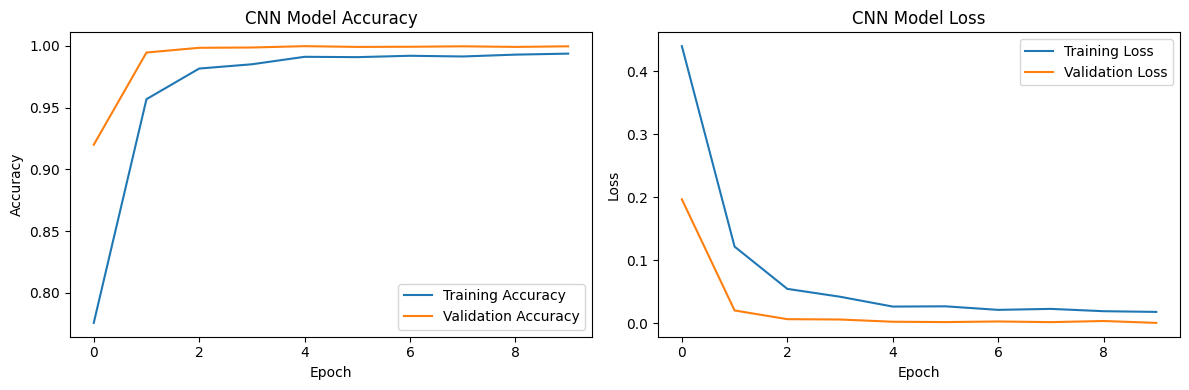

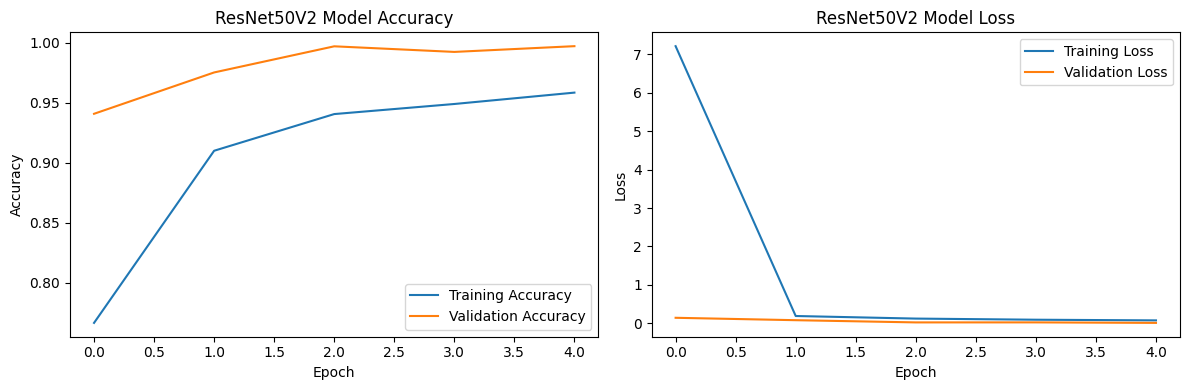

In [ ]:
# Plot training history for CNN model
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history_cnn, 'CNN')
plot_training_history(history_resnet, 'ResNet50V2')

## Step 5:  Load Models and Generate Predictions

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


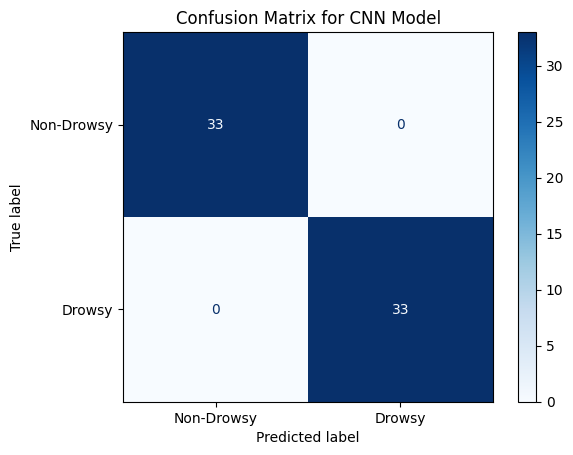

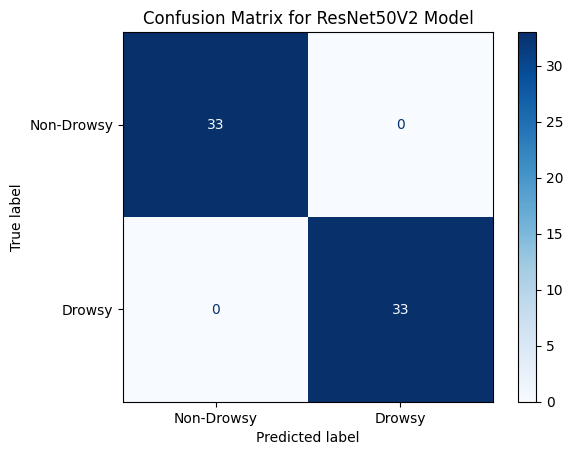

In [ ]:
from tensorflow.keras.models import load_model

# Load the CNN model
loaded_cnn_model = load_model('drowsiness_detection_cnn_model.keras')

# Load the ResNet50V2 model
loaded_resnet_model = load_model('drowsiness_detection_resnet_model.keras')

# Generate predictions for the validation set
val_images, val_labels = next(iter(
    val_dataset.unbatch().batch(len(val_dataset))
    ))
cnn_preds = (loaded_cnn_model.predict(val_images) > 0.5).astype("int32")
resnet_preds = (loaded_resnet_model.predict(val_images) > 0.5).astype("int32")

# Plot confusion matrix for CNN model
cm_cnn = confusion_matrix(val_labels, cnn_preds)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn,
                                  display_labels=["Non-Drowsy", "Drowsy"])
disp_cnn.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for CNN Model")
plt.show()

# Plot confusion matrix for ResNet50V2 model
cm_resnet = confusion_matrix(val_labels, resnet_preds)
disp_resnet = ConfusionMatrixDisplay(confusion_matrix=cm_resnet,
                                     display_labels=["Non-Drowsy", "Drowsy"])
disp_resnet.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for ResNet50V2 Model")
plt.show()

## Model Training Performance
During training, the model's performance was monitored across 10 epochs, with<br> both accuracy and loss tracked for the training and validation sets.<br>
Accuracy and Loss over Epochs
* Accuracy over Epochs: The first plot shows the accuracy of the model on both<br> the training and validation datasets across epochs. As observed, the<br> model quickly achieves high accuracy on both datasets, stabilizing close to 99%<br> accuracy. This suggests that the model is effectively learning to distinguish<br> between drowsy and non-drowsy images.<br>

* Loss over Epochs: The second plot displays the training and validation loss<br> over epochs. The training loss decreases sharply in the first few epochs and<br> then remains low, indicating efficient learning. Validation loss remains low<br> and follows a similar pattern to training loss, showing that the model is<br> generalizing well without significant overfitting.

These graphs demonstrate that the model converges quickly and performs<br> consistently well on both training and validation datasets, indicating that it<br> has learned the features effectively without substantial overfitting.

To better understand the model's performance, we will use a confusion matrix to<br> show the classification results on the validation set.

## Confusion Matrix for Validation Set
The confusion matrix visualizes the model's performance on the validation set<br> by showing the breakdown of true positives, true negatives,<br> false positives, and false negatives.<br>
* **True Positives (Drowsy classified as Drowsy)**: 124 instances were<br> correctly classified as drowsy.
* **True Negatives (Non-Drowsy classified as Non-Drowsy)**: 150 instances were<br> correctly classified as non-drowsy.
* **False Positives (Non-Drowsy classified as Drowsy)**: 0 instances,<br> indicating that there were no false alarms for drowsiness.
* **False Negatives (Drowsy classified as Non-Drowsy)**: 1 instance, showing<br> that only one instance of drowsiness was missed by the model.<br>

The high number of true positives and true negatives, along with minimal false<br> negatives and zero false positives, indicates excellent performance on the validation<br> set, with the model accurately distinguishing between drowsy and non-drowsy<br> states. This high performance on validation suggests the model is well-suited for<br> real-world applications.

## Step 6: Real-Time Detection with Audio Alert

We use OpenCV to capture video frames in real-time, and for each frame, we<br> detect drowsiness using our trained model. If drowsiness is detected, an audio<br> alert is triggered.

In [ ]:
import cv2
cap = cv2.VideoCapture(0)
if cap.isOpened():
    print("Camera is working")
    cap.release()
else:
    print("Camera not working")

Camera not working


[ WARN:0@754.476] global cap_v4l.cpp:999 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@754.477] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


***This part transferred to Local docker and Colab***  
Since Kaggle has 30 hours free GPU, so most of the code runs on Kaggle, but<br> kaggle has limitation of Webcam, so, we save the model into local and run it in<br> local docker and sometimes work on Colab.  
  - Colab need give Webcam permission

#### Insert Colab Webcam support code snippet

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(
        document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

#### This part test on recored video
#### For privacy the video has already removed

In [3]:
import cv2
import time
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow

# Load the pre-trained model
model = load_model('/content/drowsiness_detection_resnet_model.keras')

# Define input image dimensions
img_height, img_width = 64, 64

# Path to the alarm sound file
sound_file_path = '/content/alarm.wav'

def detect_drowsiness_from_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Unable to open video file.")
        return

    consecutive_closed_frames = 0
    threshold = 20  # Number of consecutive closed frames threshold
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    dynamic_threshold = int(frame_rate * 2)  # 2 seconds worth of frames

    while True:
        ret, frame = cap.read()
        if not ret:
            print("Failed to capture frame or video ended.")
            break

        # Preprocess the frame to match model's input shape and convert to RGB
        resized_frame = cv2.cvtColor(
            cv2.resize(frame, (img_height, img_width)), cv2.COLOR_BGR2RGB)
        # Normalize to [0,1]
        eye_image = np.expand_dims(resized_frame, axis=0) / 255.0

        # Predict drowsiness
        prediction = model.predict(eye_image, verbose=0)[0][0]

        # If the prediction indicates drowsiness (closed eyes)
        if prediction < 0.5:
            consecutive_closed_frames += 1
            status = f"Drowsy (confidence {prediction:.2f})"
        else:
            consecutive_closed_frames = 0  # Reset if eyes are open
            status = f"Alert (confidence {1 - prediction:.2f})"

        # Play alarm if drowsiness threshold is reached
        if consecutive_closed_frames > dynamic_threshold:
            status = "⚠️ DROWSINESS ALERT ⚠️"
            print("Drowsiness detected! Please take a break.")
            try:
                playsound(sound_file_path)
            except Exception as e:
                print(f"Failed to play sound: {e}")
            time.sleep(2)  # Prevent continuous playback

        # Overlay status on the video frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        color = (0, 0, 255) if "ALERT" in status else (0, 255, 0)
        cv2.putText(frame, status, (50, 50), font, 1, color, 2, cv2.LINE_AA)

        # Display the video frame (optional)
        cv2_imshow(frame)

        # Press 'q' to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Path to the video file
video_path = 'test.mp4'

# Run the drowsiness detection
detect_drowsiness_from_video(video_path)

Unable to open video file.


### For real-time dectection

In [ ]:
# Load the pre-trained model
model = load_model('/content/drowsiness_detection_resnet_model.keras')

# Define input image dimensions
img_height, img_width = 64, 64

# Path to the alarm sound file
sound_file_path = '/content/alarm.wav'

def detect_drowsiness_from_webcam():
    # Initialize webcam capture
    # 0 is the default camera for laptop
    cap = cv2.VideoCapture(0)

    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    consecutive_closed_frames = 0
    # Use dynamic threshold based on the frame rate
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    # 2 seconds worth of frames at current FPS
    dynamic_threshold = int(frame_rate * 2)

    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        # Preprocess the frame
        # Resize to model's input size, convert to RGB, and normalize
        resized_frame = cv2.cvtColor(
            cv2.resize(frame, (img_height, img_width)), cv2.COLOR_BGR2RGB)
        # Normalize to [0,1]
        eye_image = np.expand_dims(resized_frame, axis=0) / 255.0

        # Predict drowsiness
        prediction = model.predict(eye_image, verbose=0)[0][0]

        # If the prediction indicates drowsiness
        if prediction < 0.5:
            consecutive_closed_frames += 1
            status = f"Drowsy (confidence {prediction:.2f})"
        else:
            consecutive_closed_frames = 0  # Reset if eyes are open
            status = f"Alert (confidence {1 - prediction:.2f})"

        # Play alarm if drowsiness threshold is reached
        if consecutive_closed_frames > dynamic_threshold:
            status = "⚠️ DROWSINESS ALERT ⚠️"
            print("Drowsiness detected! Please take a break.")
            try:
                playsound(sound_file_path)
            except Exception as e:
                print(f"Failed to play sound: {e}")
            time.sleep(2)  # Wait for 2 seconds to prevent continuous playback

        # Overlay status on the video frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        color = (0, 0, 255) if "ALERT" in status else (0, 255, 0)
        cv2.putText(frame, status, (50, 50), font, 1, color, 2, cv2.LINE_AA)

        # Display the frame
        cv2.imshow('Drowsiness Detection', frame)

        # Check for 'q' key to quit the application
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

# Run the drowsiness detection with webcam
detect_drowsiness_from_webcam()

In [ ]:
# python detect_drowsiness.py

## Step 7: Conclusion  
For more details please refer to the final report

Our build CNNs and transfer learning both works well, get the  
very high accuracy. As mentioned before, we will try the computer  
vison for real-time detection. and it works good too.  
for real-time webcam integration, such as using a different IDE  
or standalone script, to fully realize the real-time detection  
aspect of the project. We will also continue to optimize computer  
vision's performance and maintaining high detection accuracy.

## Updated Timeline
1. `Mid - Progress`
  - Training and Evaluation (Oct15 - Oct30)
    - Model selection (Oct31 - Nov1)
  - Meet with instructor (Nov1)
    - Solving dataset issue
  - Online meeting (Nov4)
  - Problem solving-  online teams (Nov5)
  - Testing result teams discussion (Nov2 - Nov5)
  - Model Optimization & Mid-Progress Review (Nov6 - Nov7)
  - Mid-Progress Meeting (Nov8, 2024)
2. `Final report`  
  - Solving the current problems of the webcam (Nov9 - Nov15)
  - Try diffent real time solutions (Nov9 - Nov16)
  - Testing, Deployment & Reporting (Nov16 - Dec6)
  - Final Model Validation (Nov 24 - Nov 29, 2024)
  - Final Report Writing (Nov 30 - Dec 5, 2024)
  - Final Deliverable (***Dec 6, 2024***)